# A notebook to identify two different anatomical structures to show in Fig. 1g

Goal: Identify two AS in the same organ that have a low cosine similarity in terms of cell type population

## `import` statements

In [12]:
from pprint import pprint
import pandas as pd
import requests
from io import StringIO
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams

## Load hra-pop data

### AS-AS similarities

In [3]:
# make sure https://github.com/x-atlas-consortia/hra-pop/tree/main/ is cloned to the same root folder as this repository
# let's read this report that lists AS-AS similarities for all AS in HRApop
df_similarity_report = pd.read_csv("../../hra-pop/output-data/v0.10.2/reports/atlas/figure-as-as-sim.csv")

# let's sort by cosime similarity so we can find two instances with a low cosine similarity
df_similarity_report = df_similarity_report.sort_values(by="cosine_sim")

df_similarity_report_filtered = df_similarity_report[(
    df_similarity_report['organ'] == "heart") & (df_similarity_report['sex'] == "Male")]
print(df_similarity_report_filtered)

            organId  organ   sex            modality              as1_label  \
160  UBERON:0000948  heart  Male  sc_transcriptomics    left cardiac atrium   
105  UBERON:0000948  heart  Male  sc_transcriptomics    left cardiac atrium   
186  UBERON:0000948  heart  Male  sc_transcriptomics   right cardiac atrium   
107  UBERON:0000948  heart  Male  sc_transcriptomics   right cardiac atrium   
168  UBERON:0000948  heart  Male  sc_transcriptomics    left cardiac atrium   
170  UBERON:0000948  heart  Male  sc_transcriptomics   right cardiac atrium   
162  UBERON:0000948  heart  Male  sc_transcriptomics   heart left ventricle   
103  UBERON:0000948  heart  Male  sc_transcriptomics  heart right ventricle   
172  UBERON:0000948  heart  Male  sc_transcriptomics   right cardiac atrium   
158  UBERON:0000948  heart  Male  sc_transcriptomics  heart right ventricle   

                   as2_label  cosine_sim  as1_dataset_count  as2_dataset_count  
160  interventricular septum    0.318037         

### Load cell type populations for AS

In [4]:
# Get data via grlc
url = "https://grlc.io/api-git/hubmapconsortium/ccf-grlc/subdir/hra-pop//cell_types_in_anatomical_structurescts_per_as.csv"

# Make the HTTP GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV data into a DataFrame
    data = StringIO(response.text)
    df_hra_api = pd.read_csv(data)
    print(df_hra_api.head())  # Print the first few rows of the DataFrame
else:
    print(f"Failed to retrieve data: {response.status_code}")

             organ                                             as as_label  \
0  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
1  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
2  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
3  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
4  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   

      sex        tool            modality  \
0  Female  celltypist  sc_transcriptomics   
1  Female  celltypist  sc_transcriptomics   
2  Female  celltypist  sc_transcriptomics   
3  Female  celltypist  sc_transcriptomics   
4  Female  celltypist  sc_transcriptomics   

                                             cell_id           cell_label  \
0         https://purl.org/ccf/ASCTB-TEMP_smc-plpp2-         SMC (PLPP2+)   
1  https://purl.org/ccf/ASCTB-TEMP_cycling-plasma...  Cycling plasma cell   
2  https://purl.org/ccf/ASCTB

## Functions

In [5]:
def get_cell_type_population(as_label: str, tool:str, sex:str, hra_api_response: pd.DataFrame):
    """Gets the cell type population for the provided as_label (string) from the HRA API

    Args:
                    as_label (str): human-readable label for the desired anatomical structure
                    
    Returns:    
                    result (dict): with cell labels, percentages, and the anatomical structure
    """
    # set up the result as a dict
    result = {
        'Cell Type': [],
        'Anatomical Structure': [],
        'Cell Percentage': []
    } 
    
    # filter
    filtered_df = hra_api_response[(hra_api_response['as_label'] == as_label) & (hra_api_response['tool'] == tool) & (hra_api_response['sex'] == sex)]
    
    # get cell type and percentage pairs
    values = filtered_df[['cell_label', 'cell_percentage']]
    
    result['Cell Type'] = values['cell_label']
    result['Anatomical Structure'] = [as_label] * len(values['cell_label'])
    result['Cell Percentage'] = values['cell_percentage']

    return pd.DataFrame(result)

## Prepare the data for visualization

In [6]:
# Filter the right data
as_label_1 = "left cardiac atrium"
as_label_2 = "interventricular septum"
tool = "azimuth"
sex = "Female"

# get cell types and percentages for both
as_1_cells = get_cell_type_population(as_label_1, tool, sex, df_hra_api)
as_2_cells = get_cell_type_population(as_label_2, tool, sex, df_hra_api)

# set filter
as_1_cells = as_1_cells[(as_1_cells['Cell Percentage'] >= 0.05)]
as_2_cells = as_2_cells[(as_2_cells['Cell Percentage'] >= 0.05)]

# concatenate the two data frames
concatenated_df = pd.concat([as_1_cells, as_2_cells], ignore_index=True)
concatenated_df

,Cell Type,Anatomical Structure,Cell Percentage
0,Atrial Cardiomyocyte,left cardiac atrium,0.321545
1,Pericyte,left cardiac atrium,0.187391
2,Fibroblast,left cardiac atrium,0.147331
3,Capillary Endothelial,left cardiac atrium,0.124877
4,Ventricular Cardiomycoyte,interventricular septum,0.368072
5,Capillary Endothelial,interventricular septum,0.181801
6,Fibroblast,interventricular septum,0.151964
7,Pericyte,interventricular septum,0.133297


## Visualize

C:\Users\abueckle\AppData\Local\Temp\2\ipykernel_44656\1131227060.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])


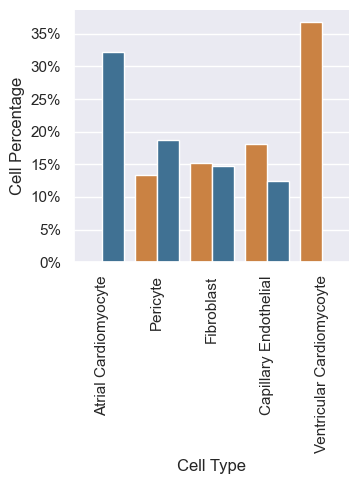

In [23]:
# Set order for bars
group_order = ['interventricular septum', 'left cardiac atrium']

# set colors
custom_palette = {'interventricular septum': '#E1812C',
                  'left cardiac atrium': '#3274A1'}

# create grouped bar graph using seaborn
plot = sns.catplot(
    data=concatenated_df,
    x='Cell Type',
    y='Cell Percentage',
    hue='Anatomical Structure',
    kind='bar',
    height=5,
    aspect=.75,
    # legend_out=False,
    legend=False,
    hue_order=group_order,
    palette=custom_palette
)

# convert y-axis to percent
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])

# rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# tighten the layout
plt.tight_layout()

# save the fig
plt.savefig("output/fig-1g.svg")
plt.savefig("output/fig-1g.pdf")
plt.savefig("output/fig-1g.png")

# render the plot
plt.show()